# Week 4 of Introduction to Biological System Design
## Introduction to Feedback Systems
### Ayush Pandey

Pre-requisite: To get the best out of this notebook, make sure that you have the basic understanding of ordinary differential equations. For more information on ODEs you may refer to any standard book on engineering math. To learn more about how to numerically simulate ODEs, refer to [week3_intro_ode.ipynb](https://pages.hmc.edu/pandey/reading/week3_intro_ode.ipynb)

# Problem Setup
Throughout this notebook, we refer to a system model with the following equations:

$\frac{dx}{dt} = f(x,u,t)\\
y = h(x,u,t)$

where the function $f(x,u,t)$ models the progression of states $x$ under inputs $u$ and the output of the system is given by $y$, modeled using a nonlinear function $h$. We make certain smoothness assumptions on this nonlinear system description as we discuss numerical analysis tools. For more information on the smoothness assumptions, please refer to a standard text on nonlinear dynamics (for example: Nonlinear Systems by Hassan Khalil). In this notebook, we discuss the basics of feedback systems and employ numerical simulations to elucidate the key properties of feedback.


### Principle of Feedback
Use of feedback is extensive in all engineered and natural systems. The basic idea behind a feedback system is to sense the performance of the system and actuate it so that the observed performance is close to the desired performance. Use of feedback has been shown to vastly improve performance of systems, ranging from an operational amplifier in electronic circuits to homeostasis in biological systems. Some key properties of feedback are:

### Feedback Properties
1. Controlled dynamical response
2. Robustness to uncertainty
3. Disturbance rejection 
4. Oscillations/instability/multi-stability

Refer to [BFS](http://www.cds.caltech.edu/~murray/books/AM08/pdf/bfs-intro_14Sep14.pdf) for more information. 

# Input-Output System: A biological example

Biologists have engineered switching behavior by regulating gene expression in bacteria. Read the paper by [Gardner et al. 2000](https://www.nature.com/articles/35002131) for more details. If we have two genes $A$ and $B$ that repress each other under control of inducer molecules $u_1$ and $u_2$ then it is possible to show that this gene regulatory network exhibits a bistable behavior - that is, it has two stable equilibrium points. Dependent on the input signal, the system would either express gene $A$ or gene $B$, giving rise to a "toggle switch" behavior.

## Circuit Diagram
The interaction diagram is shown using dnaplotlib below:

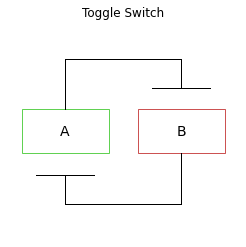

In [222]:
import dnaplotlib as dpl
gene_A = {'type':'UserDefined', 'name':'A', 'opts': {'color':[0.38, 0.82, 0.32],
                                               'label':'A', 'label_size':14,
                                               'label_y_offset':0}}
gene_B = {'type':'UserDefined', 'name':'B', 'opts': {'color':[0.8, 0.32, 0.32],
                                               'label':'B', 'label_size':14,
                                               'label_y_offset':0}}
repress_A = {'from_part':gene_B, 'to_part':gene_A, 'type':'Repression', 
             'opts':{'linewidth':1, 'color':[0, 0, 0], 'arc_height':-10,
             'arc_height_start':-3, 'arc_height_end':-6},
             'fwd':True
            }
repress_B = {'from_part':gene_A, 'to_part':gene_B, 'type':'Repression', 
               'opts':{'linewidth':1, 'color':[0, 0, 0],
                       'arc_height':10,'arc_height_start':3, 
                       'arc_height_end':6}
            }
import matplotlib.pyplot as plt
%matplotlib inline
ax = plt.axes()
dr = dpl.DNARenderer()
start, end = dr.renderDNA(ax, [gene_A, gene_B], regs = [repress_A, repress_B], 
                          part_renderers = dr.SBOL_part_renderers(), 
                          reg_renderers = dr.std_reg_renderers(), 
                          plot_backbone = False)
ax.set_xlim([start, end])
ax.set_ylim([-15,15])
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Toggle Switch')
ax.axis('off');

## Nonlinear mathematical model

Consider the following model of a bistable switch (Gardner et al. 2000 and BFS Ch. 5):

$\frac{dA}{dt} = \frac{\beta}{1 + \left(\frac{B}{K_B(u_2)}\right)^n} - \gamma A$

$\frac{dB}{dt} = \frac{\beta}{1 + \left(\frac{A}{K_A(u_1)}\right)^n} - \gamma B$

where

$K_A(u_1) = K\left(1 + \frac{u_1}{K_{d_1}}\right)$
and 
$K_B(u_2) = K\left(1 + \frac{u_2}{K_{d_2}}\right)$

In this system description, we have $x = \begin{bmatrix}A \\ B\end{bmatrix}$, $u = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$, and $y = \begin{bmatrix}A \\ B\end{bmatrix}$, that is both states are also outputs, so $y = x$. 

## Simulation

To simulate the mathematical model given above, we use odeint as demonstrated in [week3_intro_ode.ipynb](https://pages.hmc.edu/pandey/reading/week3_intro_ode.ipynb).

### Define the ODE

In [181]:
def toggle_switch(x, t, *args):
    # Get all parameters and inputs
    beta, gamma, K, K_d1, K_d2, n, u1, u2 = args
    # Compute lumped input parameters
    K_A = K*(1 + u1/K_d1)
    K_B = K*(1 + u2/K_d2)
    
    # Compute RHS of ODE
    # Here x = [A, B] so A = x[0] and B = x[1]
    dx_dt = np.zeros_like(x)
    dx_dt[0] = beta/(1 + (x[1]/K_B)**n) - gamma * x[0]
    dx_dt[1] = beta/(1 + (x[0]/K_A)**n) - gamma * x[1]
    return dx_dt

from scipy.integrate import odeint
import numpy as np

# Parameter values from BFS Figure 5.3
beta = 1
gamma = 1
K_d1 = 1
K_d2 = 1
K = np.sqrt(0.1)
n = 2

# Switch B on by setting u1 = 1 (repress A) and u2 = 0
u1 = 1
u2 = 0
initial_values = np.array([0, 0])
timepoints = np.linspace(0,50,100)
solution_switchA = odeint(func = toggle_switch, y0 = initial_values, t = timepoints, 
                  args = (beta, gamma, K, K_d1, K_d2, n, u1, u2))

# Switch A on by setting u2 = 1 and u1 = 0
u1 = 0
u2 = 1
# Continue simulation with changed values
new_timepoints = np.linspace(timepoints[-1], 100, 100)
solution_switchB = odeint(func = toggle_switch, y0 = solution_switchA[-1,:], t = new_timepoints, 
                  args = (beta, gamma, K, K_d1, K_d2, n, u1, u2))

solution = np.concatenate((solution_switchA, solution_switchB), axis = 0)
total_timepoints = np.concatenate((timepoints, new_timepoints))

### Controlled dynamical in response to inputs: 

After t = 50, the input signals are switched so that u2 = 1 and u1 = 0. We observe that the we can control the system switching behavior by switching the input signals (in this case, by adding chemical inducers to the solution). This demonstrates a key feature of feedback systems, that we can design dynamical response of a system in a controlled manner.

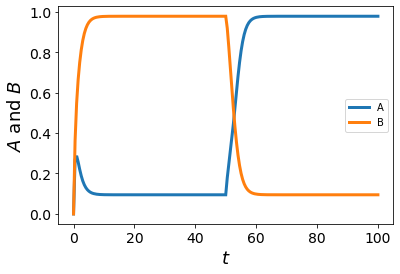

In [182]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(total_timepoints, solution[:,0], lw = 3, label = 'A')
ax.plot(total_timepoints, solution[:,1], lw = 3, label = 'B')
ax.set_xlabel('$t$', fontsize = 18)
ax.set_ylabel('$A$ and $B$', fontsize = 18)
ax.tick_params(labelsize = 14)
ax.legend();

You can compare odeint performance with your numerical integrator by running both simultaneously.

##  Robustness to uncertainty in feedback systems

Initial condition response (for differing initial concentrations of protein B in the solution)

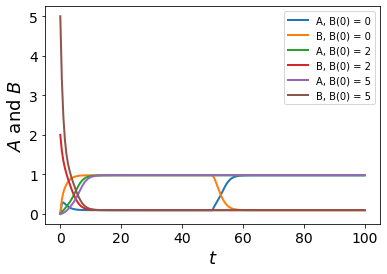

In [233]:
beta = 1
gamma = 1
K_d1 = 1
K_d2 = 1
K = np.sqrt(0.1)
n = 2

# Switch B on by setting u1 = 1 (repress A) and u2 = 0
u1 = 1
u2 = 0
# Set different initial conditions for concentration of protein B
ax = plt.axes()
for B0 in [0,2,5]:
    initial_values = np.array([0, B0])
    timepoints = np.linspace(0,50,100)
    solution_switchA = odeint(func = toggle_switch, y0 = initial_values, t = timepoints, 
                      args = (beta, gamma, K, K_d1, K_d2, n, u1, u2))

    # Switch A on by setting u2 = 1 and u1 = 0
    u1 = 0
    u2 = 1
    # Continue simulation with changed values
    new_timepoints = np.linspace(timepoints[-1], 100, 100)
    solution_switchB = odeint(func = toggle_switch, y0 = solution_switchA[-1,:], t = new_timepoints, 
                      args = (beta, gamma, K, K_d1, K_d2, n, u1, u2))

    solution = np.concatenate((solution_switchA, solution_switchB), axis = 0)
    total_timepoints = np.concatenate((timepoints, new_timepoints))
    ax.plot(total_timepoints, solution[:,0], lw = 2, label = 'A, B(0) = ' + str(B0))
    ax.plot(total_timepoints, solution[:,1], lw = 2, label = 'B, B(0) = ' + str(B0))
ax.set_xlabel('$t$', fontsize = 18)
ax.set_ylabel('$A$ and $B$', fontsize = 18)
ax.tick_params(labelsize = 14)
ax.legend();

Initial condition response (for differing initial concentrations of protein A in the solution)

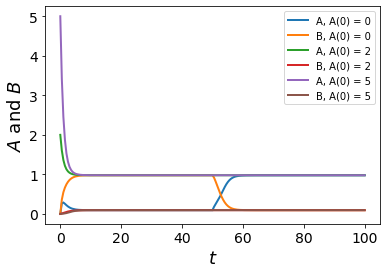

In [234]:
beta = 1
gamma = 1
K_d1 = 1
K_d2 = 1
K = np.sqrt(0.1)
n = 2

# Switch B on by setting u1 = 1 (repress A) and u2 = 0
u1 = 1
u2 = 0
# Set different initial conditions for concentration of protein B
ax = plt.axes()
for A0 in [0,2,5]:
    initial_values = np.array([A0, 0])
    timepoints = np.linspace(0,50,100)
    solution_switchA = odeint(func = toggle_switch, y0 = initial_values, t = timepoints, 
                      args = (beta, gamma, K, K_d1, K_d2, n, u1, u2))

    # Switch A on by setting u2 = 1 and u1 = 0
    u1 = 0
    u2 = 1
    # Continue simulation with changed values
    new_timepoints = np.linspace(timepoints[-1], 100, 100)
    solution_switchB = odeint(func = toggle_switch, y0 = solution_switchA[-1,:], t = new_timepoints, 
                      args = (beta, gamma, K, K_d1, K_d2, n, u1, u2))

    solution = np.concatenate((solution_switchA, solution_switchB), axis = 0)
    total_timepoints = np.concatenate((timepoints, new_timepoints))
    ax.plot(total_timepoints, solution[:,0], lw = 2, label = 'A, A(0) = ' + str(A0))
    ax.plot(total_timepoints, solution[:,1], lw = 2, label = 'B, A(0) = ' + str(A0))
ax.set_xlabel('$t$', fontsize = 18)
ax.set_ylabel('$A$ and $B$', fontsize = 18)
ax.tick_params(labelsize = 14)
ax.legend();

## Multi-stability in feedback systems: